# Imbalanced Data

**Goal:** To explore features of the dataset, use visualizations to help in understanding those features, and develop a model that solves the problem of imbalanced data nu under- and over-sampling.

In [15]:
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### Import Data

In [22]:
def wrangle(url):
    df = pd.read_csv(url)
    #Re-code the class variable to True = 1, and False = 0:
    df['class'] = df['class'].replace({0: False, 1: True})
    
    #Rename the class variable to bankrupt
    df = df.rename(columns={'class': 'bankrupt'})

    return df

In [23]:
df = wrangle("https://archive.ics.uci.edu/static/public/365/data.csv")
df.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_21300\125355118.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'] = df['class'].replace({0: False, 1: True})


,year,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A56,A57,A58,A59,A60,A61,A62,A63,A64,bankrupt
0,1,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,False
1,1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,False
2,1,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,False
3,1,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,False
4,1,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,False


**Important Note**: Class: Whether a company went bankrupt(1) or a company that did not go bankrupt(0)

Explore

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      43405 non-null  int64  
 1   A1        43397 non-null  float64
 2   A2        43397 non-null  float64
 3   A3        43397 non-null  float64
 4   A4        43271 non-null  float64
 5   A5        43316 non-null  float64
 6   A6        43397 non-null  float64
 7   A7        43397 non-null  float64
 8   A8        43311 non-null  float64
 9   A9        43396 non-null  float64
 10  A10       43397 non-null  float64
 11  A11       43361 non-null  float64
 12  A12       43271 non-null  float64
 13  A13       43278 non-null  float64
 14  A14       43397 non-null  float64
 15  A15       43369 non-null  float64
 16  A16       43310 non-null  float64
 17  A17       43311 non-null  float64
 18  A18       43397 non-null  float64
 19  A19       43277 non-null  float64
 20  A20       43278 non-null  fl

In [25]:
df.shape

(43405, 66)

In [26]:
df.head(3)

,year,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A56,A57,A58,A59,A60,A61,A62,A63,A64,bankrupt
0,1,0.20055,0.37951,0.39641,2.0472,32.3510,0.38825,0.24976,1.33050,1.1389,...,0.12196,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,False
1,1,0.20912,0.49988,0.47225,1.9447,14.7860,0.00000,0.25834,0.99601,1.6996,...,0.12130,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,False
2,1,0.24866,0.69592,0.26713,1.5548,-1.1523,0.00000,0.30906,0.43695,1.3090,...,0.24114,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,False


Plot Class Balance

In [28]:
df["bankrupt"].value_counts(normalize=True)

bankrupt
False    0.951826
True     0.048174
Name: proportion, dtype: float64

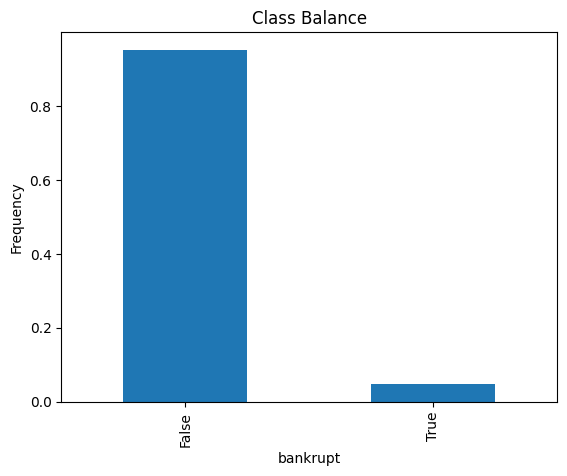

In [29]:
# Plot class balance
df["bankrupt"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="bankrupt",
    ylabel="Frequency",
    title="Class Balance"
);

- Positive Class: True

- Negative class: False

Feature Box Plot: Feature A27

- A7: profit on operating activities/ expenses

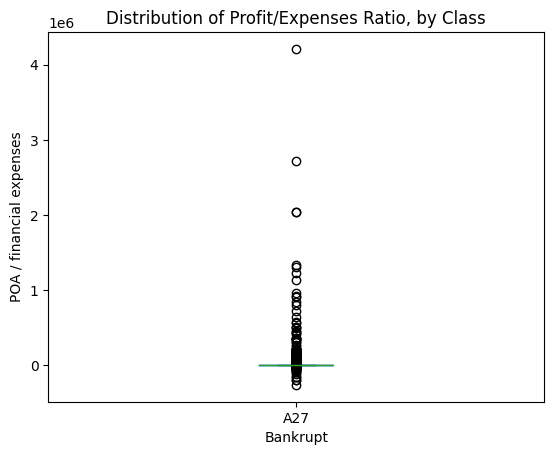

In [32]:
df["A27"].plot(
    kind="box"
)
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Class");